# Регуляризация

В рамках задания предлагается улучшить качество модели, подверженной переобучению.

Загрузим корпус MNIST и оставим 10000 тренировочных примеров.

USE CUDA: True
Train size: 1000
Test size: 10000


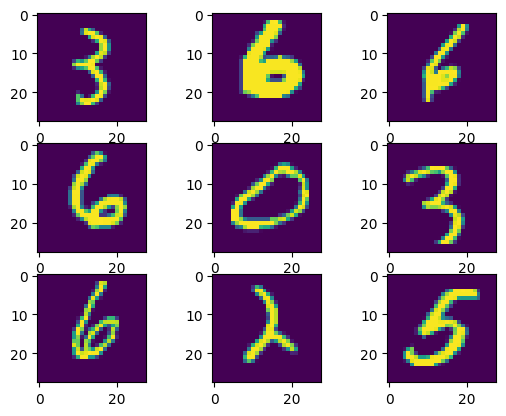

In [8]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

USE_CUDA = torch.cuda.is_available()
print("USE CUDA:", USE_CUDA)

torch.manual_seed(0)
np.random.seed(0)

SUBSET_SIZE = 1000
BATCH_SIZE = 32

transform = torchvision.transforms.ToTensor()

train = MNIST("mnist", train=True, transform=transform, download=True)
train = torch.utils.data.Subset(train, np.random.permutation(len(train))[:SUBSET_SIZE])
test = MNIST("mnist", train=False, transform=transform, download=True)
print("Train size:", len(train))
print("Test size:", len(test))

def draw(dataset):
    images, labels = zip(*[dataset[i] for i in range(9)])
    fig, axs = plt.subplots(3, 3, squeeze=False)
    for i, image in enumerate(images):
        ax = axs[i // 3, i % 3]
        ax.imshow(image.permute(1, 2, 0).squeeze(-1))
    plt.show()

draw(train)

In [15]:
def compute_accuracy(model, loader):
    if USE_CUDA:
        model.cuda()
    model.eval()
    n_correct = 0
    n = 0
    for images, labels in tqdm(loader, leave=False):
        if USE_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        n_correct += (model(images).argmax(dim=1) == labels).sum().item()
        n += len(images)
    return n_correct / n

In [ ]:
def run(model, epoch_count=5, **optimizer_kwargs):
    print("Num parameters", sum(map(torch.numel, model.parameters())))
    if USE_CUDA:
        model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=optimizer_kwargs.get("lr", 0.1),
                                **optimizer_kwargs)
    loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, drop_last=True)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
    train_accuracies = []
    test_accuracies = []
    for epoch in trange(epoch_count):
        model.train()
        losses = []
        for images, labels in loader:
            if USE_CUDA:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        model.eval()
        train_accuracy = compute_accuracy(model, loader)
        test_accuracy = compute_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch}, loss {np.mean(losses):.3f}, train {train_accuracy:.3f}, test {test_accuracy:.3f}")
    print("Weights norm", torch.linalg.norm(torch.concat([p.flatten() for p in model.parameters()])).item())
    plt.ylim(train_accuracies[1], 1)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_accuracies, label="Train", marker="o")
    plt.plot(test_accuracies, label="Test", marker="o")
    plt.legend()
    plt.show()
    
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)
        
run(model)

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model, weight_decay=0.05)

При `weight_decay=0.05` точность на train падает на 4.3%, а на test на 1.4%. Таким образом переобучение становится меньше, но качество на test падает.

**Задание 1**. Может ли выбор `weight_decay` увеличить точность на train? Какой максимальной точности на test можно добиться подбором этого параметра? Может ли точность на train и test примерно сравняться?

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)

run(model, weight_decay=0.03)  # Ваш параметр.

**Задание 2.** Добавьте `torch.nn.Dropout`, подберите параметр и увеличьте точность на test до 90% или выше. Изменилось ли число параметров модели? Вырастает ли при этом точность на train?

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Dropout(p=0.05),

    torch.nn.Conv2d(1, 4, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),

    torch.nn.Conv2d(4, 8, 3, stride=2),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),

    torch.nn.Flatten(),

    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(288, 10)
)  # Добавьте dropout в модель.

run(model)

**Задание 3** Добавить BatchNorm2d в модель. Изменилось ли при этом число параметров модели? Увеличьте точность на test до 89% или выше. Насколько можно увеличить точность на train?

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),

    torch.nn.Conv2d(4, 8, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),

    torch.nn.Flatten(),
    torch.nn.Linear(288, 10)
)  # Добавьте BatchNorm2d в модель (возможно несколько раз).

run(model, epoch_count=15)

**Задание 4.** Попробуйте добиться точности 92% или выше на test используя все предыдущие способы (можно добиться 93%+).

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Dropout(p=0.05),

    torch.nn.Conv2d(1, 4, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),

    torch.nn.Conv2d(4, 8, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),

    torch.nn.Flatten(),

    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(288, 10)
)

run(model, epoch_count=100)

In [ ]:
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.BatchNorm2d(1, affine=False),

    torch.nn.Conv2d(1, 4, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(4),
    torch.nn.ReLU(),

    torch.nn.Conv2d(4, 8, 3, stride=2, bias=False),
    torch.nn.BatchNorm2d(8),
    torch.nn.ReLU(),

    torch.nn.Flatten(),

    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(288, 10)
)

run(model, epoch_count=20,)